# Az adatállományról

Az adatállományt a **Roboflow** oldal Universe részlegén a "*traffic signs*" kulcsszók használtatával találtam meg. Több különböző adathalmazt találtam, ami ígéretesnek tűnt, ezek közül kiválasztottam hármat, amelyeknek a training mappájában 6000 és 10000 közötti adatmennyiség volt. Ezek közül kiválasztottam azt, amelyiknek bár a legkevesebb adatmennyisége volt, mégis ez rendelkezett a legtöbb információval, így például a másik két adathalmazzal ellentétben nem volt 0-s osztálya. Ez az adathalmaz **7980** tartalmaz.

A képek **640x640**-es méretűek, ami véleményem szerint jó minőségűnek számítanak, figyelembe véve, hogy a gyorsabb futási idő elérésében le kell skáláznom őket, továbbá egységesítve van a méret.

Az adathalmaz tehát olyan képeket tartalmaz, ami közlekedési táblákat, jelzőtáblákat tartalmaz. Ezt arra használjuk, hogy az elkészülő modell fel tudja ismerni a különböző táblákat.

Az adathalmazban a következő képpen preprocesszálták a képeket:
* "*Auto-orientation of pixel data (with EXIF-orientation stripping)*" - automatikus tájolás a pixel adatok alapján
* "*Resize to 640x640 (Stretch)*" - újraméretezés 640x640-es méretre
* "*Auto-contrast via contrast stretching*" - auto kontrasztolás kontraszt nyújtással

Az adathalmazban három féle képpen módosították a képeket:
* "*Random brigthness adjustment of between -25 and +25 percent*" - random világosság -25 és 25 százalék között
* "*Random exposure adjustment of between -25 and +25 percent*" - random expozíció, megvilágítási idő -25 és 25 százalék között
* "*Salt and pepper noise was applied to 7 percent of pixels*" - magas frekvenciájú zaj használata a pixelek 7 százalékán

Az adathalmazt a letöltés idejében (2024.04.20) 8 hónapja frissítették és 74 osztály van megjelölve, többek között stop tábla, különböző sebességkorlát táblák (10, 100, 5, 50, 90 stb.), gyalogátjáró tábla stb.

Az adathalmazt a következő [linken](https://universe.roboflow.com/sit-asmsw/road-sign-detection-in-real-time)  el lehet érni.

Az adathalmazban levő adatokat egy script segítségével az adott csoport nevekkel rendelkező mappákba rendeztem, ezt a könyvtárakhoz tartozó .csv fájlok segítségével tettem. Ezeknek egy másik scripttel megnéztem a darabszámot, hogy hány képet tartalmaznak, leellenőriztem, hogy azok, amik 100 és 200 közötti darabszámmal rendelkeztek, mennyire egységes a bennük levő képek kinézete. Például ne tartalmazzon olyan táblát, amely más kategóriába tartozna vagy országonként nagyon eltérő. Amennyiben egy jó adatmennyiséggel rendelkező könyvtárban nem odaillő képek is voltak, ezeket korrigáltam. Például 60-as tábláknál ne legyen 130-as. Ezután kiválasztottam azt a 11 mappát, amely megfelelőnek bizonyult, tehát 140-200 közötti adatmennyiséggel rendelkezett és helyes képek voltak bennük. Ezeket a mappákat ezt követően feltöltöttem a Google Drive-ra, ahonnan majd a modell tanításához is importáltam.

Ezzel az adatmennyiséggel nem működött jól a modell, ezért a kiugró darabszámmal rendelkező mappákat lecsökkentettem 160 körülire. Az adatmennyiség csökkentése nem segítette elő a modell hatékonnyá tételét, ezért egy másik adathalmazból újabb adatokat adtam a már meglévő adathalmazhoz. Ez a következő [linken](https://universe.roboflow.com/kendrickxy/european-road-signs) érhető el.

Emellett több más adathalmazt is kerestem a konkrét tábláknak:

*   https://universe.roboflow.com/study-bgzay/hump-ycncu
*   https://universe.roboflow.com/major-project-166na/indian-traffic-signboards
*   https://universe.roboflow.com/clerusync/demo-ybuex
*   https://universe.roboflow.com/ikbal/traffic-signs-bqale
*   https://datasetninja.com/road-sign-detection


# Traffic Sign Recognition CNN Keras

Tartalom:

*   Különböző modulok importálása
*   Adatok preprocesszálása, előkészítése
*   Modellezés
*   Tanítás
*   Modell teljesítményék kiértékelése
*   Előrejelzések vizualizálása a validációs adathalmazon



# Különböző modulok importálása

In [11]:
!nvidia-smi

Sun Apr 28 19:54:13 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [12]:
# Az adatokat a Google Drive segítségével importáljuk be
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [13]:
pip install visualkeras

In [14]:
# Figyelmen kívül hagyja a figyelmeztetéseket
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

# adatvizualizáció és -manipuláció
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from matplotlib import style
import seaborn as sns
import visualkeras

#configure
# a matplotlib-ot inline-ra állítja, és megjeleníti a grafikonokat a megfelelő cella alatt
%matplotlib inline
style.use('fivethirtyeight')
sns.set(style='whitegrid',color_codes=True)

#modell kiválasztása
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix,roc_curve,roc_auc_score
from sklearn.preprocessing import LabelEncoder

#előfeldolgozás
from keras.preprocessing.image import ImageDataGenerator

#dl könyvtárak
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop
from keras.utils import to_categorical

# kifejezetten a CNN részére
from keras.layers import Dropout, Flatten,Activation
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization, AveragePooling2D
from keras.layers import LeakyReLU

import tensorflow as tf
import random as rn

# kifejezetten a zippelt képek manipulálására és a képek pixelértékeit tartalmazó numpy tömbök kinyerésére
import cv2
import os
from tqdm import tqdm

# Adatok preprocesszálása, előkészítése

## A képekből a training és a validation készlet kinyerésére szolgáló függvények elkészítése

In [15]:
X=[]
Z=[]
IMG_SIZE=128 # erdemes kisebb merettel dolgozni pl. 128
STOP_DIR='/content/drive/My Drive/train/Stop'
STEEP_DESCENT_DIR='/content/drive/My Drive/train/Steep Descent'
SPEED_LIMIT_80_DIR='/content/drive/My Drive/train/Speed Limit 80'
SPEED_LIMIT_20_DIR='/content/drive/My Drive/train/Speed Limit 20'
RIGHT_REVERSE_BEND_DIR='/content/drive/My Drive/train/Right Reverse Bend'
PEDESTRIAN_CROSSING_DIR='/content/drive/My Drive/train/Pedestrian Crossing'
HUMP_DIR='/content/drive/My Drive/train/Hump'
GIVE_WAY_DIR='/content/drive/My Drive/train/Give Way'
FALLING_ROCKS_DIR='/content/drive/My Drive/train/Falling Rocks'
SPEED_LIMIT_50_DIR='/content/drive/My Drive/train/Speed Limit 50'
BARRIER_AHEAD_DIR='/content/drive/My Drive/train/Barrier Ahead'

In [16]:
def assign_label(img,sign_type):
    return sign_type

In [17]:
def make_train_data(sign_type,DIR):
    for img in tqdm(os.listdir(DIR)):
        label=assign_label(img,sign_type)
        path = os.path.join(DIR,img)
        img = cv2.imread(path,cv2.IMREAD_COLOR)
        im_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # beolvassuk szines kepkent
        im_rgb = cv2.resize(im_rgb, (IMG_SIZE,IMG_SIZE))

        X.append(np.array(im_rgb))
        Z.append(str(label))

In [18]:
make_train_data('Stop', STOP_DIR)
print(len(X))

100%|██████████| 373/373 [00:18<00:00, 19.70it/s]

373


In [19]:
make_train_data('Steep_Descent', STEEP_DESCENT_DIR)
print(len(X))

100%|██████████| 296/296 [00:07<00:00, 37.53it/s] 

669


In [20]:
make_train_data('Speed_Limit_80', SPEED_LIMIT_80_DIR)
print(len(X))

100%|██████████| 388/388 [00:17<00:00, 21.93it/s]

1057


In [21]:
make_train_data('Speed_Limit_20', SPEED_LIMIT_20_DIR)
print(len(X))

100%|██████████| 311/311 [00:16<00:00, 18.73it/s]

1368


In [22]:
make_train_data('Right_Reverse_Bend', RIGHT_REVERSE_BEND_DIR)
print(len(X))

100%|██████████| 304/304 [00:11<00:00, 27.17it/s]

1672


In [23]:
make_train_data('Pedestrian_Crossing', PEDESTRIAN_CROSSING_DIR)
print(len(X))

100%|██████████| 460/460 [00:17<00:00, 26.48it/s]

2132


In [24]:
make_train_data('Hump', HUMP_DIR)
print(len(X))

100%|██████████| 270/270 [00:09<00:00, 29.14it/s]

2402


In [25]:
make_train_data('Give_Way', GIVE_WAY_DIR)
print(len(X))

100%|██████████| 470/470 [00:14<00:00, 32.37it/s] 

2872


In [26]:
make_train_data('Falling_Rocks', FALLING_ROCKS_DIR)
print(len(X))

100%|██████████| 340/340 [00:12<00:00, 28.04it/s]

3212


In [27]:
make_train_data('Speed_Limit_50', SPEED_LIMIT_50_DIR)
print(len(X))

100%|██████████| 450/450 [00:14<00:00, 31.56it/s]

3662


In [28]:
make_train_data('Barrier_Ahead', BARRIER_AHEAD_DIR)
print(len(X))

100%|██████████| 366/366 [00:10<00:00, 34.05it/s] 

4028


## Visualizing the Classes

In [29]:
# Initialize a dictionary to store the count of images in each class
class_count = {}
data_dir = "/content/drive/My Drive/train"
# Iterate over the directories in the data directory
for class_name in os.listdir(data_dir):
    class_dir = os.path.join(data_dir, class_name)
    if os.path.isdir(class_dir):
        # Count the number of files in the directory (assuming each file is an image)
        num_images = len(os.listdir(class_dir))
        # Store the count for this class
        class_count[class_name] = num_images

# Sort classes by image count in ascending order
sorted_classes = sorted(class_count.items(), key=lambda x: x[1])

# Extract class names and image counts
class_names = [item[0] for item in sorted_classes]
image_counts = [item[1] for item in sorted_classes]

# Define custom colors for each bar
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#fcba03', '#03fc0f', '#6f03fc', '#fc039d', '#e88ed7', '#8ee8d1', '#dbd8ab', '#081bc7']

# Create a bar plot using Plotly
fig = go.Figure(data=[go.Bar(
    x=image_counts,
    y=class_names,
    orientation='h',
    marker_color=colors
)])

# Customize layout
fig.update_layout(
    title='Number of Images in Each Class',
    xaxis_title='Number of Images',
    yaxis_title='Class',
    yaxis=dict(autorange="reversed"),  # Invert y-axis to have the class with the highest count at the top
)

# Show plot
fig.show()

## Néhány véletlenszerű kép vizualizációja

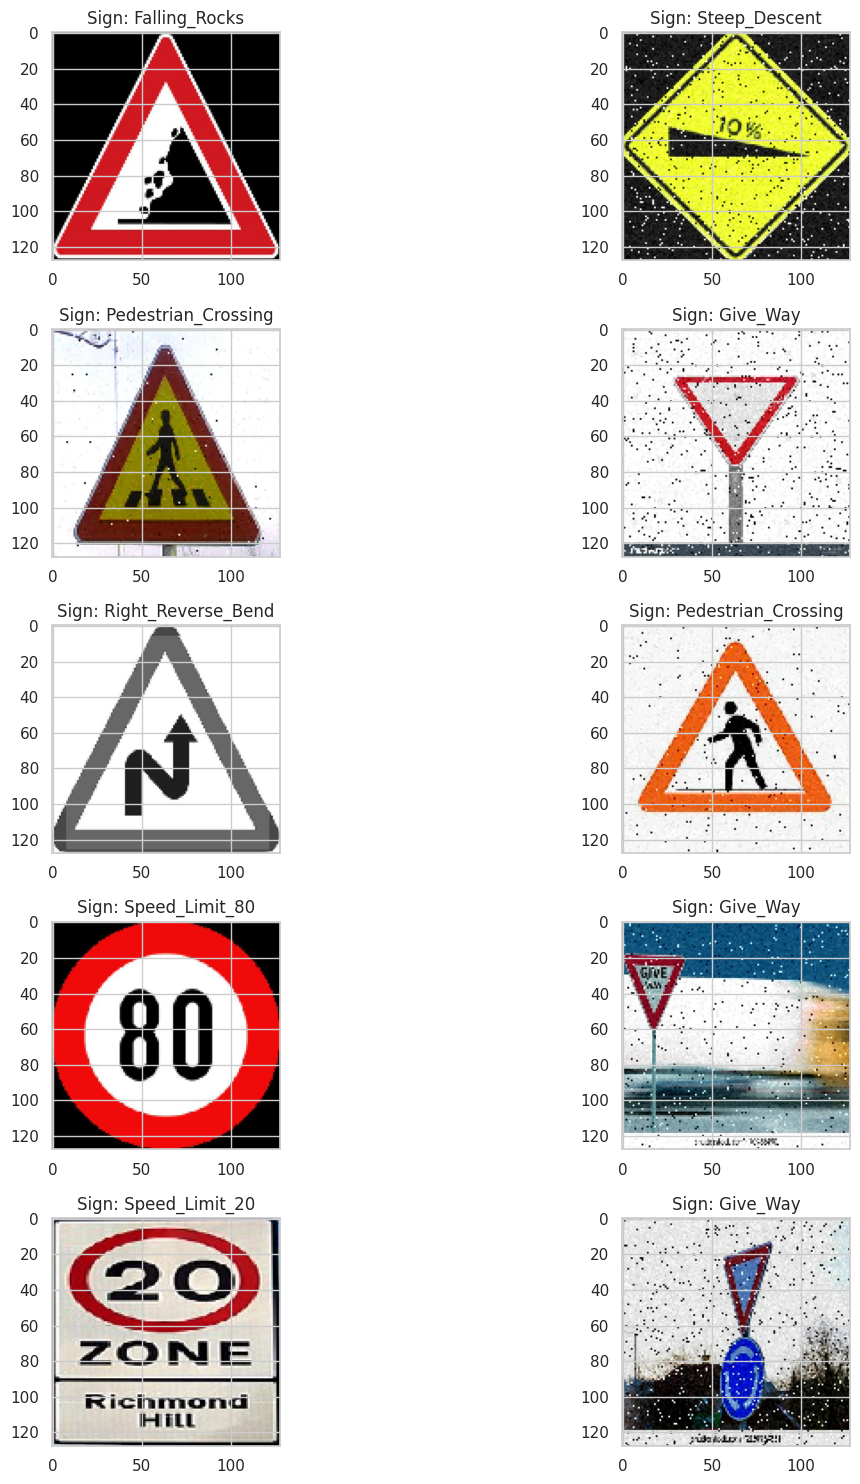

In [30]:
fig,ax=plt.subplots(5,2)
fig.set_size_inches(15,15)
for i in range(5):
    for j in range (2):
        l=rn.randint(0,len(Z))
        ax[i,j].imshow(X[l])
        ax[i,j].set_title('Sign: '+Z[l])

plt.tight_layout()

##  Címkekódolás az Y tömbben, majd One Hot Encoding

In [31]:
le=LabelEncoder()
Y=le.fit_transform(Z)
Y=to_categorical(Y,11)
X=np.array(X)
X=X/255

## Felosztás képzési és validálási halmazokra

In [122]:
x_train,x_test,y_train,y_test=train_test_split(X,Y,test_size=0.03,random_state=42)

## A véletlen magok beállítása

In [123]:
np.random.seed(42)
rn.seed(42)
tf.random.set_seed(42)

# Modellezés

## A ConvNet modell felépítése

In [124]:
# modelling starts using a CNN.
model = Sequential()
model.add(Conv2D(filters=32, kernel_size=(5,5), padding='same', input_shape=(128,128,3)))
model.add(Conv2D(filters=32, kernel_size=(3,3), padding='same'))
model.add(LeakyReLU(alpha=0.015))
model.add(AveragePooling2D(pool_size=(2,2), strides=(2,2)))

model.add(Conv2D(filters=64, kernel_size=(3,3), padding='same'))
model.add(Conv2D(filters=64, kernel_size=(3,3), padding='same'))
model.add(LeakyReLU(alpha=0.015))
model.add(AveragePooling2D(pool_size=(2,2), strides=(2,2)))

model.add(Conv2D(filters=64, kernel_size=(3,3), padding='same'))
model.add(Conv2D(filters=64, kernel_size=(3,3), padding='same'))
model.add(LeakyReLU(alpha=0.015))
model.add(AveragePooling2D(pool_size=(2,2), strides=(2,2)))

model.add(Conv2D(filters=128, kernel_size=(3,3), padding='same'))
model.add(Conv2D(filters=128, kernel_size=(3,3), padding='same'))
model.add(LeakyReLU(alpha=0.015))
model.add(AveragePooling2D(pool_size=(2,2), strides=(2,2)))

# Dropout réteg hozzáadása (x%-os Dropout rate)
# model.add(Dropout(0.3))

model.add(Flatten())
model.add(Dense(128))
model.add(LeakyReLU(alpha=0.015))

model.add(Dense(11, activation = "softmax"))

## LR lágyító használata

In [125]:
batch_size=64
epochs=35

from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
red_lr= ReduceLROnPlateau(monitor='val_accuracy',patience=10,verbose=1,factor=0.015)
model_checkpoint = ModelCheckpoint(filepath='model_.{epoch:02d}-{val_loss:.6f}.h5', save_best_only=True, verbose=1)
early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)

## Adatbővítés a túlillesztés megakadályozására

In [126]:
datagen = ImageDataGenerator(
    rotation_range=5,  # Reduced from 10 to make less drastic rotations
    zoom_range=0.05,  # Reduced from 0.1 for slight zooming
    width_shift_range=0.1,  # Reduced from 0.2
    height_shift_range=0.1,  # Reduced from 0.2
    horizontal_flip=True,  # Keep as is, assuming no orientation-specific features
    fill_mode='nearest'  # Good for filling up the new pixels
)

datagen.fit(x_train)

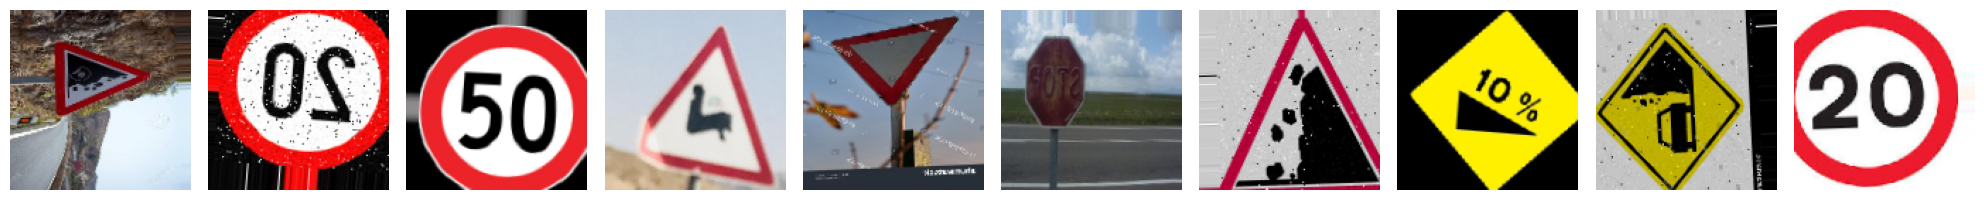

In [127]:
# Visualize some images

def plot_images(images_arr):
    fig, axes = plt.subplots(1, 10, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

# Generating a batch of images
sample_images, _ = next(datagen.flow(x_train, y_train, batch_size=10))
plot_images(sample_images)


## A Keras modell fordítása és összefoglaló

In [128]:
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [129]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_32 (Conv2D)          (None, 128, 128, 32)      2432      
                                                                 
 conv2d_33 (Conv2D)          (None, 128, 128, 32)      9248      
                                                                 
 leaky_re_lu_20 (LeakyReLU)  (None, 128, 128, 32)      0         
                                                                 
 average_pooling2d_16 (Aver  (None, 64, 64, 32)        0         
 agePooling2D)                                                   
                                                                 
 conv2d_34 (Conv2D)          (None, 64, 64, 64)        18496     
                                                                 
 conv2d_35 (Conv2D)          (None, 64, 64, 64)        36928     
                                                      

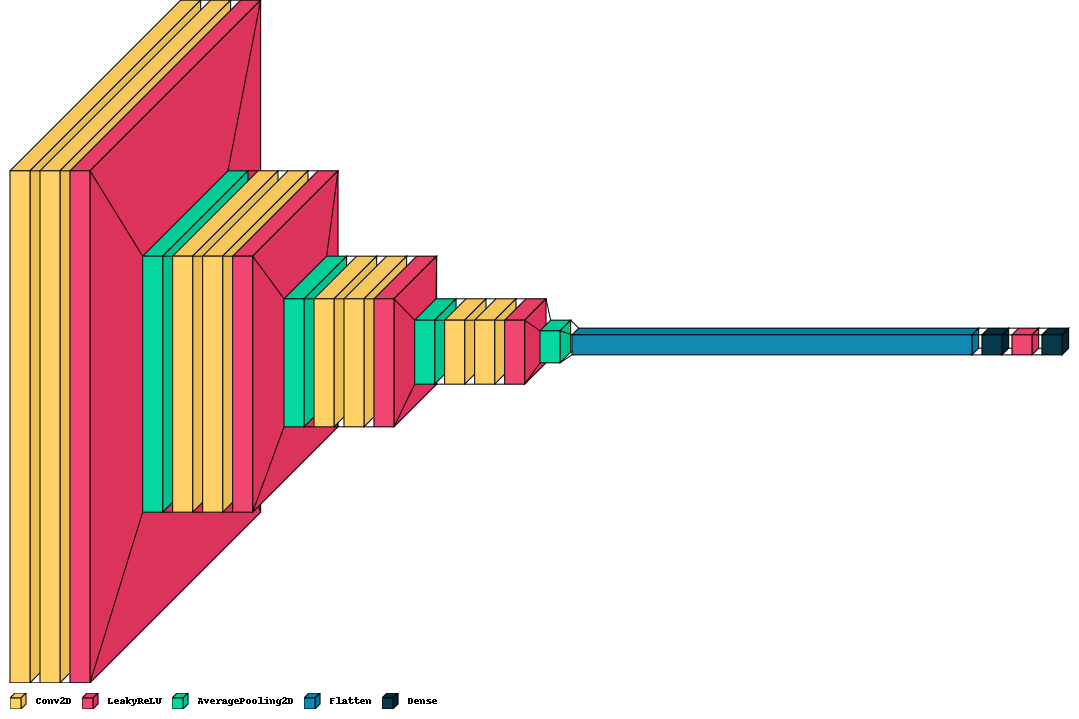

In [130]:
visualkeras.layered_view(model, legend=True)

##  Illesztés a gyakorlóhalmazon és előrejelzések készítése a validációs halmazon

In [131]:
train_generator = datagen.flow(x_train, y_train, batch_size=batch_size)

# Adjusted model.fit call
history = model.fit(
    train_generator,
    epochs=epochs,
    steps_per_epoch=len(x_train) // batch_size,  # Ensuring correct step calculation
    validation_data=(x_test, y_test),
    verbose=1,
    callbacks=[red_lr, model_checkpoint]
)

# history = model.fit(x_train,y_train,epochs=epochs,validation_data = (x_test,y_test), callbacks=[red_lr, model_checkpoint, early_stop])

Epoch 1/35
61/61 [==============================] - ETA: 0s - loss: 2.0091 - accuracy: 0.2717
Epoch 1: val_loss improved from inf to 1.58268, saving model to model_.01-1.582682.h5
61/61 [==============================] - 23s 330ms/step - loss: 2.0091 - accuracy: 0.2717 - val_loss: 1.5827 - val_accuracy: 0.3967 - lr: 0.0010
Epoch 2/35
61/61 [==============================] - ETA: 0s - loss: 1.6453 - accuracy: 0.3989
Epoch 2: val_loss improved from 1.58268 to 1.42293, saving model to model_.02-1.422934.h5
61/61 [==============================] - 17s 277ms/step - loss: 1.6453 - accuracy: 0.3989 - val_loss: 1.4229 - val_accuracy: 0.5289 - lr: 0.0010
Epoch 3/35
61/61 [==============================] - ETA: 0s - loss: 1.3856 - accuracy: 0.5100
Epoch 3: val_loss improved from 1.42293 to 0.99973, saving model to model_.03-0.999726.h5
61/61 [==============================] - 17s 284ms/step - loss: 1.3856 - accuracy: 0.5100 - val_loss: 0.9997 - val_accuracy: 0.6612 - lr: 0.0010
Epoch 4/35
61/61 

## Modell kimentése

In [132]:
model.save('/content/drive/My Drive/cnn_model_tultanitott.keras')

# Modell teljesítményék kiértékelése

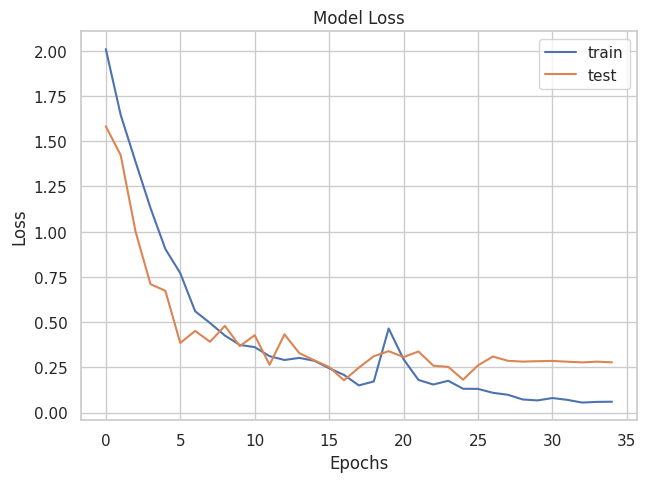

In [133]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

In [134]:
print(history.history)

{'loss': [2.009146213531494, 1.6452953815460205, 1.3856133222579956, 1.1309921741485596, 0.9040787816047668, 0.770759642124176, 0.5599950551986694, 0.4948787987232208, 0.4254729151725769, 0.37375113368034363, 0.36156198382377625, 0.3114021420478821, 0.2904745936393738, 0.3019105792045593, 0.2861519753932953, 0.24503393471240997, 0.20772528648376465, 0.14985719323158264, 0.1718292534351349, 0.46439602971076965, 0.2945311367511749, 0.17990803718566895, 0.15485134720802307, 0.1754767745733261, 0.13129161298274994, 0.13071627914905548, 0.10887651145458221, 0.09823183715343475, 0.07224448770284653, 0.06678507477045059, 0.080119788646698, 0.06997179239988327, 0.05494093522429466, 0.05872955545783043, 0.05971934273838997], 'accuracy': [0.27166277170181274, 0.3989070951938629, 0.5100182294845581, 0.6164454817771912, 0.6937288641929626, 0.74993497133255, 0.8201925754547119, 0.8462138772010803, 0.864168643951416, 0.8745771646499634, 0.8797814249992371, 0.8969554901123047, 0.9089252948760986, 0.9

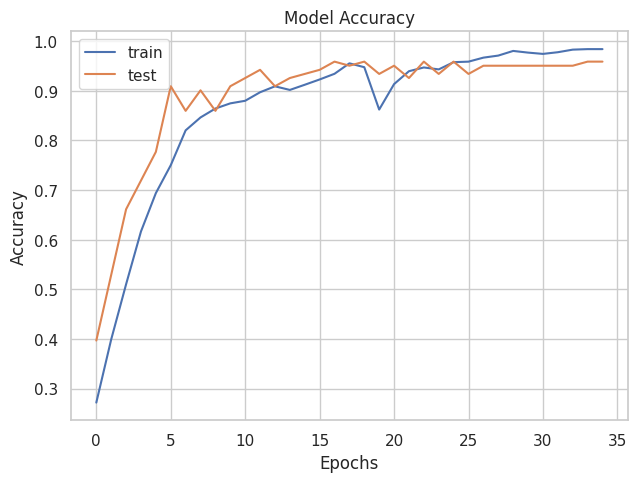

In [135]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

# Előrejelzések vizualizálása a validációs adathalmazon

In [136]:
# getting predictions on val set.
pred=model.predict(x_test)
pred_digits=np.argmax(pred,axis=1)

4/4 [==============================] - 0s 12ms/step


In [137]:
# Creating the confusion matrix
y_true = np.argmax(y_test, axis=1)  # True labels
conf_matrix = confusion_matrix(y_true, pred_digits)

In [138]:
# now storing some properly as well as misclassified indexes'.
i=0
prop_class=[]
mis_class=[]

for i in range(len(y_test)):
    if(np.argmax(y_test[i])==pred_digits[i]):
        prop_class.append(i)
    if(len(prop_class)==8):
        break

i=0
for i in range(len(y_test)):
    if(not np.argmax(y_test[i])==pred_digits[i]):
        mis_class.append(i)
    if(len(mis_class)==8):
        break

In [139]:
# Assuming labels are defined and match your class indices in the confusion matrix
labels = ["Stop", "Steep Descent", "Speed Limit 80", "Speed Limit 20",
          "Right Reverse Bend", "Pedestrian Crossing", "Hump", "Give Way",
          "Falling Rocks", "Speed Limit 50", "Barrier Ahead"]

def calculate_metrics(conf_matrix):
    metrics_list = []
    total_samples = np.sum(conf_matrix)

    for i in range(len(labels)):
        TP = conf_matrix[i, i]
        FP = np.sum(conf_matrix[:, i]) - TP
        FN = np.sum(conf_matrix[i, :]) - TP
        TN = total_samples - TP - FP - FN

        TPR = TP / (TP + FN) if (TP + FN) != 0 else 0  # True Positive Rate
        TNR = TN / (TN + FP) if (TN + FP) != 0 else 0  # True Negative Rate
        PPV = TP / (TP + FP) if (TP + FP) != 0 else 0  # Positive Predictive Value
        NPV = TN / (TN + FN) if (TN + FN) != 0 else 0  # Negative Predictive Value
        ACC = (TP + TN) / total_samples if total_samples != 0 else 0  # Accuracy
        DS = 2 * TP / (2 * TP + FP + FN) if (2 * TP + FP + FN) != 0 else 0  # Dice Score

        metrics_list.append([TP, FP, FN, TN, PPV, TPR, TNR, NPV, ACC, DS])

    return pd.DataFrame(metrics_list, columns=[
        "True Positive (TP)", "False Positive (FP)", "False Negative (FN)",
        "True Negative (TN)", "Positive Predictive Value (PPV)",
        "True Positive Rate (TPR)", "True Negative Rate (TNR)",
        "Negative Predictive Value (NPV)", "Accuracy (ACC)", "Dice Score (DS)"
    ], index=labels)

# Assuming 'conf_matrix' is already defined
metrics_df = calculate_metrics(conf_matrix)

# Save the DataFrame to CSV
csv_path = '/content/drive/My Drive/metrics_traffic_signs_overlearned.csv'
metrics_df.to_csv(csv_path, index_label="Label")

csv_path  # Output the path to the CSV for download

'/content/drive/My Drive/metrics_traffic_signs_overlearned.csv'

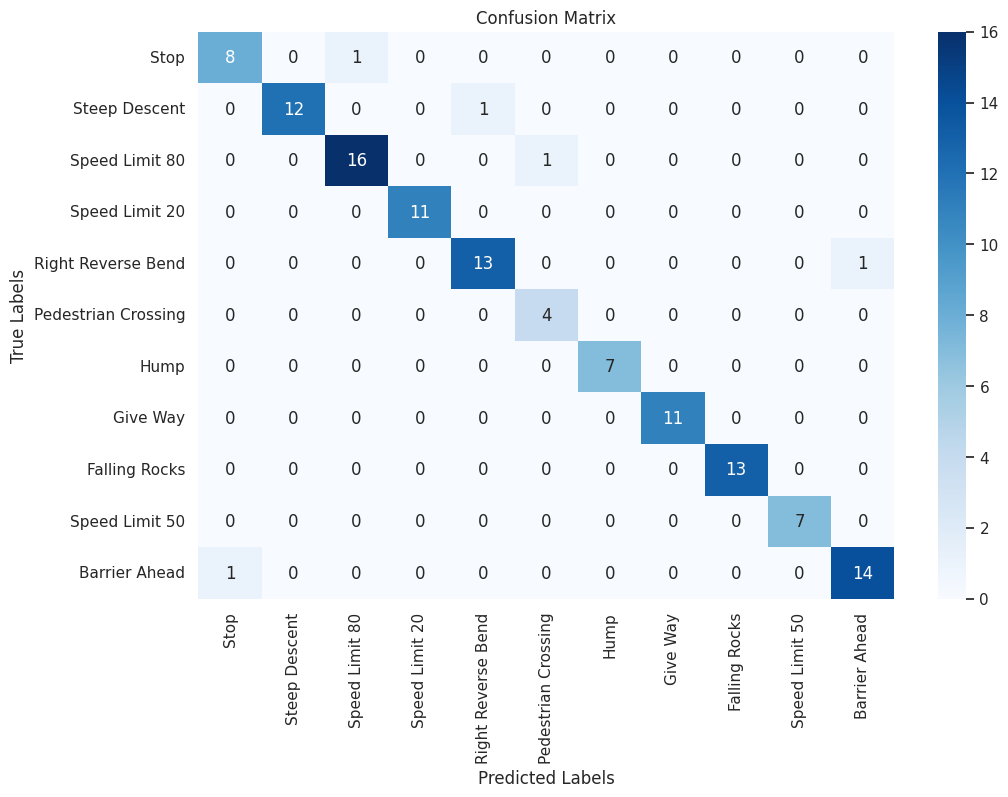

In [140]:
# Visualize the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

HELYESEN OSZTÁLYOZOTT JELZŐTÁBLÁK

In [141]:
print(le.inverse_transform([pred_digits[prop_class[0]]]))

['Hump']


In [142]:
print([y_test[prop_class[0]]])

[array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)]


In [143]:
print(le.inverse_transform(np.argmax([y_test[prop_class[0]]], axis=1)))

['Hump']


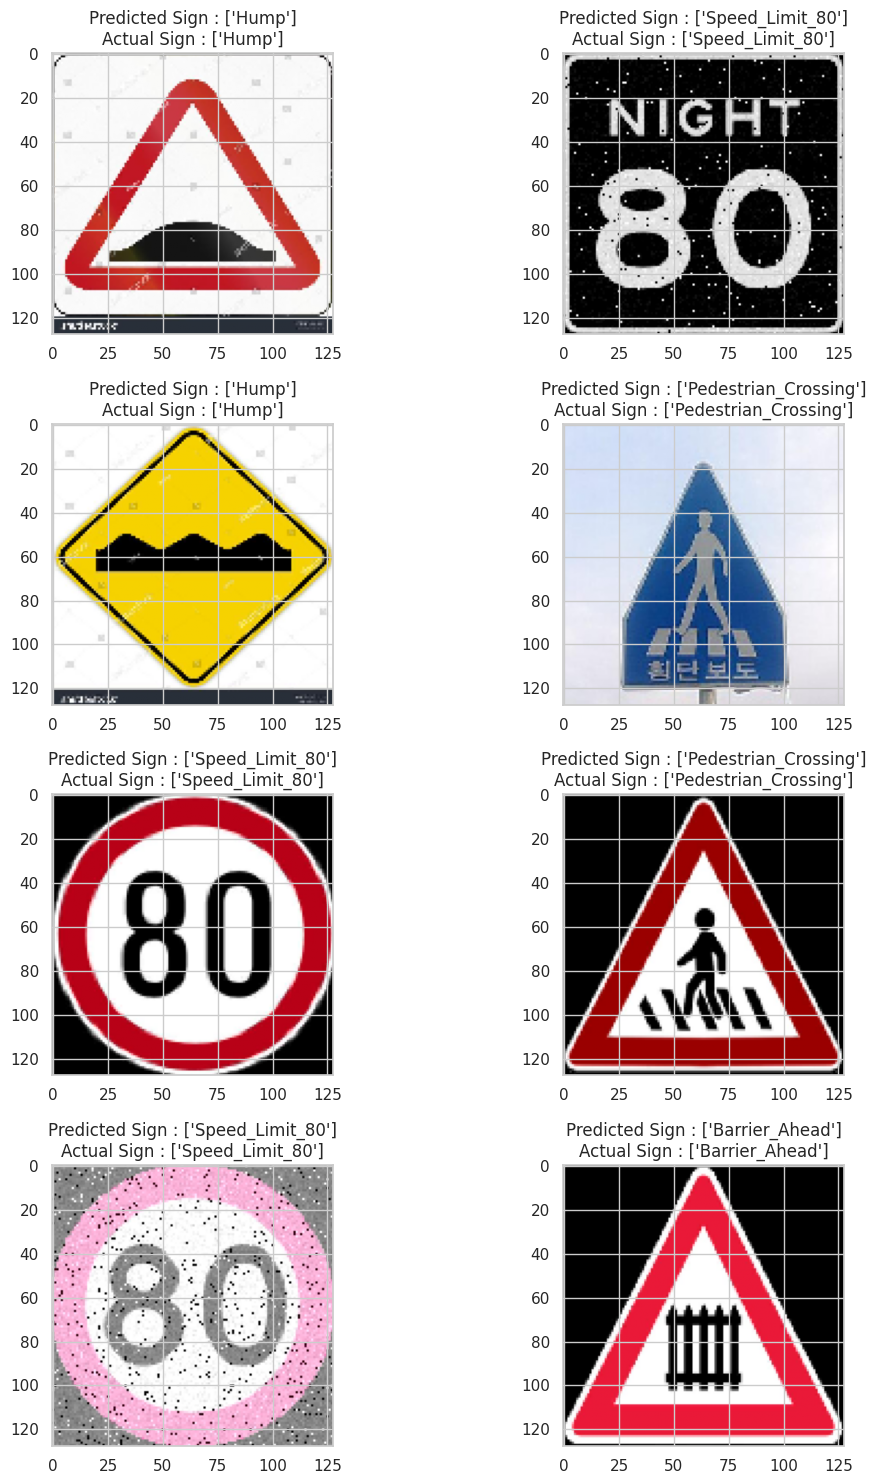

In [144]:
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

count=0
fig,ax=plt.subplots(4,2)
fig.set_size_inches(15,15)
for i in range (4):
    for j in range (2):
        ax[i,j].imshow(x_test[prop_class[count]])
        ax[i,j].set_title("Predicted Sign : "+str(le.inverse_transform([pred_digits[prop_class[count]]]))+"\n"+"Actual Sign : "+str(le.inverse_transform(np.argmax([y_test[prop_class[count]]], axis=1))))
        plt.tight_layout()
        count+=1

TÉVESEN BESOROLT JELZŐTÁBLÁK

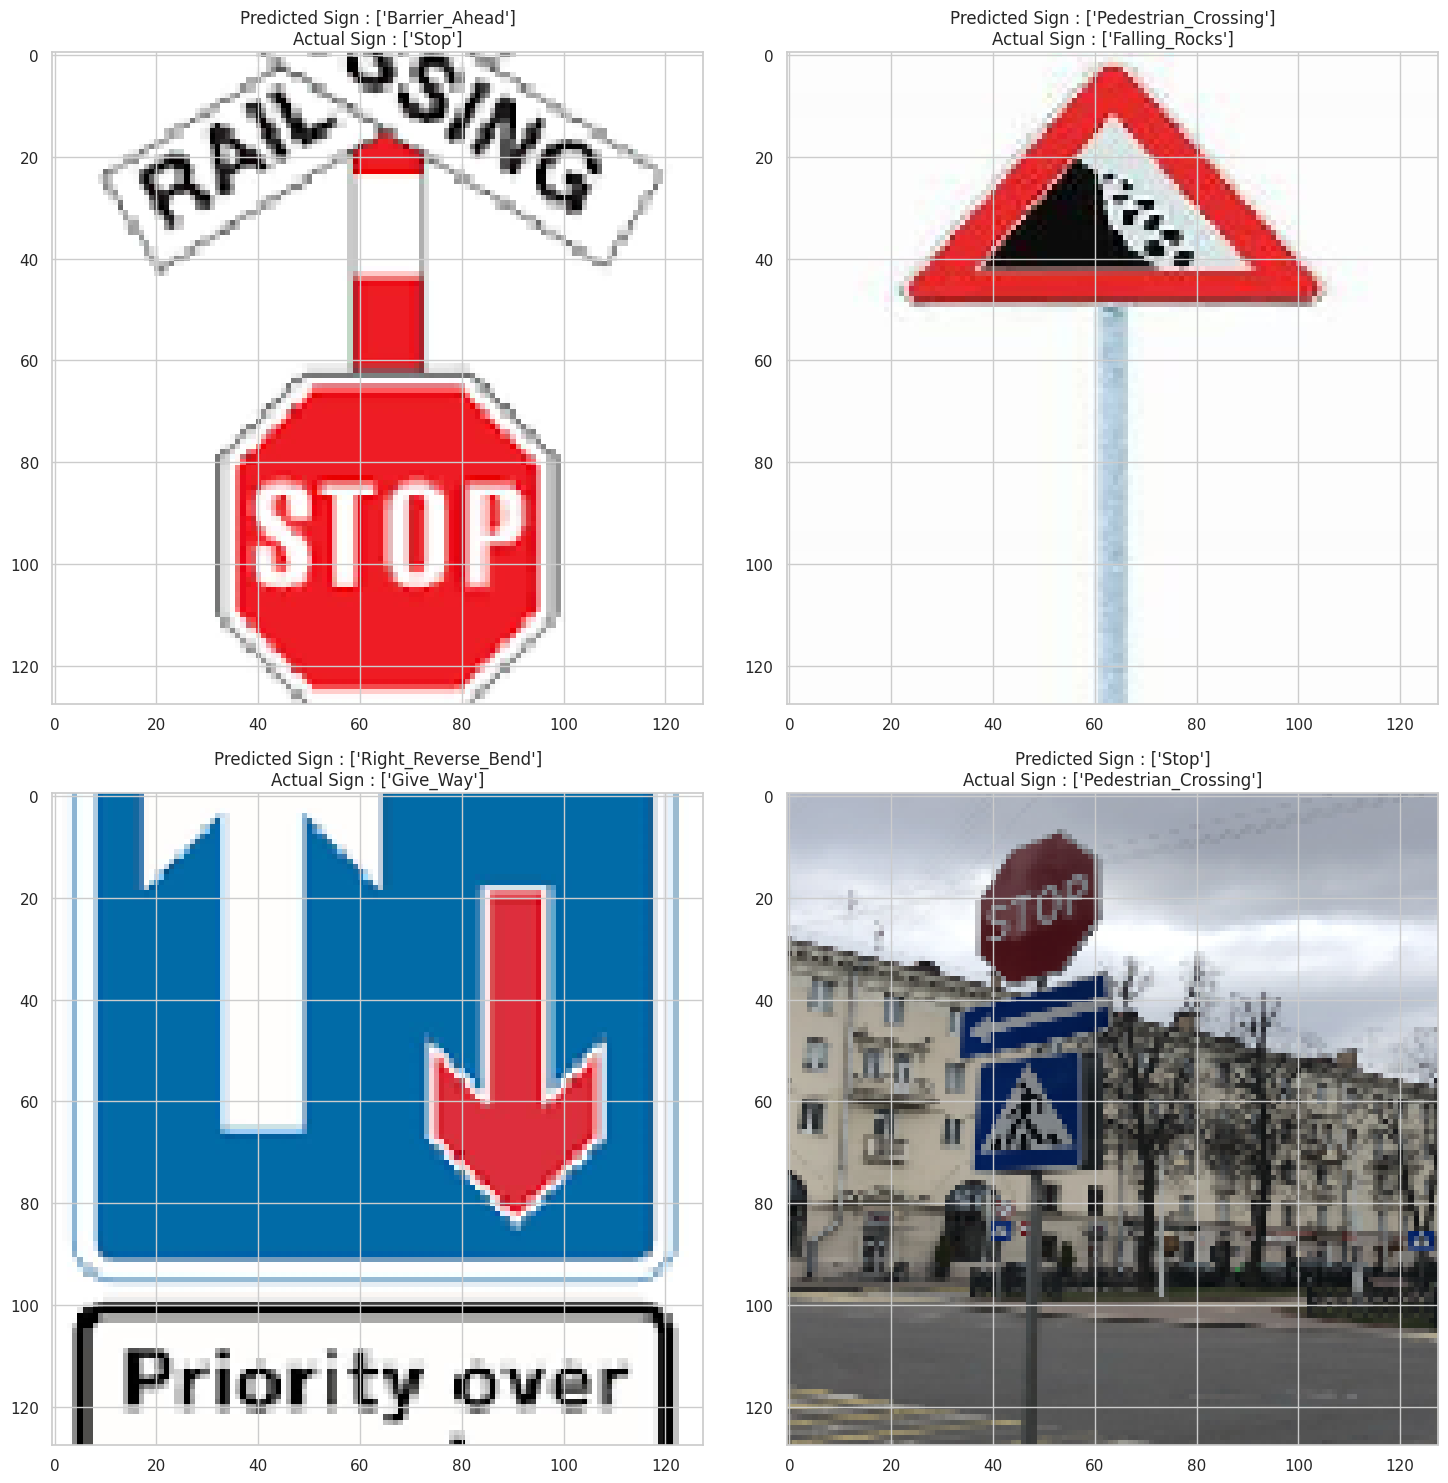

In [149]:
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

count=0
fig,ax=plt.subplots(2,2)
fig.set_size_inches(15,15)
for i in range (2):
    for j in range (2):
        ax[i,j].imshow(x_test[mis_class[count]])
        ax[i,j].set_title("Predicted Sign : "+str(le.inverse_transform([pred_digits[mis_class[count]]]))+"\n"+"Actual Sign : "+str(le.inverse_transform(np.argmax([y_test[mis_class[count]]], axis=1))))
        plt.tight_layout()
        count+=1